### Introduction to Video Data Processing Using CNN-LSTM for Construction Site Analysis

This code implements a CNN-LSTM architecture as part of the PRISM system, designed for processing and analyzing video data collected from construction sites. The CNN is used to extract spatial features from video frames, enabling the identification of critical visual elements such as object detection and motion tracking. These extracted features are then passed to an LSTM network, which captures the temporal dynamics across the sequence of frames. This approach allows for the detection of anomalies, task progress assessment, and prediction of potential issues on the construction site, ultimately supporting real-time decision-making and resource allocation.


In [5]:
import os

# Path to the dataset directory
dataset_path = 'Dataset'

# Get the list of label types (subdirectories) in the dataset directory
label_types = os.listdir(dataset_path)

# Initialize a dictionary to store the count of files in each label type
file_counts = {}

# Iterate over each label type (subdirectory)
for label in label_types:
    label_path = os.path.join(dataset_path, label)  # Full path to the subdirectory
    if os.path.isdir(label_path):  # Ensure it's a directory
        num_files = len([f for f in os.listdir(label_path) if os.path.isfile(os.path.join(label_path, f))])
        file_counts[label] = num_files

# Print the count of files in each label type
for label, count in file_counts.items():
    print(f"{label}: {count} files")


Baselayer_Preparation: 770 files
Concreting: 710 files
Mortar_Preparation: 669 files
Plaster: 709 files
Wall_Construction: 648 files


In [4]:
import os

# Get the current working directory
current_directory = os.getcwd()
print(f"The current working directory is: {current_directory}")


The current working directory is: /teamspace/studios/this_studio/Wall_test1


In [1]:
# Import the required libraries.
import os
import cv2
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, GlobalAveragePooling2D, Dropout, LSTM, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from datetime import datetime as dt

# Define constants
IMG_SIZE = 224  # Size to which each video frame will be resized
SEQUENCE_LENGTH = 20  # Number of frames to be used in each video sequence
NUM_FEATURES = 2048  # Number of features extracted from each frame
BATCH_SIZE = 4  # Batch size for training
EPOCHS = 50  # Number of epochs for training
MAX_SEQ_LENGTH = SEQUENCE_LENGTH  # Maximum sequence length

# Set seed for reproducibility
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

# Load the dataset from a CSV file
file_path = 'Data_logdf.csv'
dataset = pd.read_csv(file_path)

# Define the list of classes
CLASSES_LIST = dataset['tag'].unique()

# Function to crop the center square of the frame
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]

# Function to load video frames
def load_video(path, max_frames=MAX_SEQ_LENGTH, resize=(IMG_SIZE, IMG_SIZE)):
    if not os.path.exists(path):
        print(f"Video file {path} does not exist.")
        return np.array([])
    
    cap = cv2.VideoCapture(path)
    if not cap.isOpened():
        print(f"Error: Cannot open video file {path}")
        return np.array([])

    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]  # Convert BGR to RGB
            frames.append(frame)
            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    
    if len(frames) == 0:
        print(f"No frames found for video {path}")
    
    return np.array(frames)

# Build feature extractor using InceptionV3
def build_feature_extractor():
    feature_extractor = tf.keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = tf.keras.applications.inception_v3.preprocess_input

    inputs = tf.keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)
    outputs = feature_extractor(preprocessed)
    return tf.keras.Model(inputs, outputs, name="feature_extractor")

feature_extractor = build_feature_extractor()

# Encode labels
label_processor = tf.keras.layers.StringLookup(num_oov_indices=0, vocabulary=np.unique(dataset["tag"]))
print(label_processor.get_vocabulary())


2024-08-13 08:05:17.720288: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-13 08:05:18.597447: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-08-13 08:05:19.800103: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1096 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:35:00.0, compute capability: 8.9


['Baselayer_Preparation', 'Concreting', 'Mortar_Preparation', 'Plaster', 'Wall_Construction']


In [2]:
labels = dataset["tag"].values
labels = label_processor(labels[..., None]).numpy()
labels

array([[2],
       [2],
       [2],
       ...,
       [1],
       [1],
       [1]])

In [ ]:
# Prepare video data
def prepare_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = df["tag"].values
    labels = label_processor(labels[..., None]).numpy()

    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for idx, path in enumerate(video_paths):
        full_path = os.path.join(root_dir, path)
        frames = load_video(full_path)
        if frames.shape[0] == 0:
            continue
        print(f"Loaded {frames.shape[0]} frames for video {full_path}")
        frames = frames[None, ...]

        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
            temp_frame_mask[i, :length] = 1

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return frame_features, frame_masks, labels

# Prepare the dataset
frame_features, frame_masks, labels = prepare_videos(dataset, "")

# Split data into training and testing sets
train_features, test_features, train_masks, test_masks, train_labels, test_labels = train_test_split(
    frame_features, frame_masks, labels, test_size=0.2, random_state=seed_constant
)

# Flatten the labels to ensure they are one-dimensional
train_labels = train_labels.flatten()
test_labels = test_labels.flatten()

# Print the shapes of the data for verification
print(f"Train features shape: {train_features.shape}")
print(f"Train masks shape: {train_masks.shape}")
print(f"Train labels shape: {train_labels.shape}")
print(f"Test features shape: {test_features.shape}")
print(f"Test masks shape: {test_masks.shape}")
print(f"Test labels shape: {test_labels.shape}")

# Save the data
np.save('train_features.npy', train_features)
np.save('test_features.npy', test_features)
np.save('train_masks.npy', train_masks)
np.save('test_masks.npy', test_masks)
np.save('train_labels.npy', train_labels)
np.save('test_labels.npy', test_labels)



Loaded 20 frames for video Dataset/Mortar_Preparation/segment_1.mp4


I0000 00:00:1723536345.010838  959805 service.cc:145] XLA service 0x7f0848004570 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1723536345.010870  959805 service.cc:153]   StreamExecutor device (0): NVIDIA L4, Compute Capability 8.9
2024-08-13 08:05:45.083278: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-13 08:05:45.644476: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8900


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


I0000 00:00:1723536349.331259  959805 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Loaded 20 frames for video Dataset/Mortar_Preparation/segment_10.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━

In [1]:
import numpy as np

# Load the saved data
train_features = np.load('train_features.npy')
test_features = np.load('test_features.npy')
train_masks = np.load('train_masks.npy')
test_masks = np.load('test_masks.npy')
train_labels = np.load('train_labels.npy')
test_labels = np.load('test_labels.npy')

# Print the shapes of the loaded data
print(f"Train features shape: {train_features.shape}")
print(f"Train masks shape: {train_masks.shape}")
print(f"Train labels shape: {train_labels.shape}")
print(f"Test features shape: {test_features.shape}")
print(f"Test masks shape: {test_masks.shape}")
print(f"Test labels shape: {test_labels.shape}")

# Print some sample data for verification
print("\nSample train features[0]:")
print(train_features[0])

print("\nSample train masks[0]:")
print(train_masks[0])

print("\nSample train labels[0]:")
print(train_labels[0])

print("\nSample test features[0]:")
print(test_features[0])

print("\nSample test masks[0]:")
print(test_masks[0])

print("\nSample test labels[0]:")
print(test_labels[0])


Train features shape: (2804, 20, 2048)
Train masks shape: (2804, 20)
Train labels shape: (2804,)
Test features shape: (702, 20, 2048)
Test masks shape: (702, 20)
Test labels shape: (702,)

Sample train features[0]:
[[0.59784055 0.3003858  0.8868471  ... 0.04788424 1.41163    0.4895329 ]
 [0.46058047 0.24208236 0.82903075 ... 0.05945637 1.274545   0.4897472 ]
 [0.45598677 0.23460642 0.7549837  ... 0.16890717 1.3940386  0.45655838]
 ...
 [0.8151996  0.47676337 1.0667784  ... 0.10946652 1.5079024  0.60307455]
 [0.68041515 0.38491118 0.9514809  ... 0.04816832 1.4186392  0.63718104]
 [0.654921   0.45783043 0.85180473 ... 0.07812434 1.3192872  0.42999187]]

Sample train masks[0]:
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]

Sample train labels[0]:
3

Sample test features[0]:
[[0.6607664  0.04334331 0.62646604 ... 0.27742815 0.8681516  0.36654055]
 [0.61564523 0.09230348 0.6848887  ... 0.8303277  1.1165035  0.27453

2024-08-13 12:06:58.165759: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-13 12:06:59.719616: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-13 12:07:01.741156: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Train features shape: (2804, 20, 2048)


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │       540,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 545,413 (2.08 MB)

 Trainable params: 545,413 (2.08 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
701/701 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.2580 - loss: 1.6196 - val_accuracy: 0.6296 - val_loss: 1.2589 - learning_rate: 1.0000e-04
Epoch 2/50
701/701 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.5063 - loss: 1.2745 - val_accuracy: 0.7493 - val_loss: 0.8101 - learning_rate: 1.0000e-04
Epoch 3/50
701/701 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - accuracy: 0.6617 - loss: 0.9771 - val_accuracy: 0.7991 - val_loss: 0.6417 - learning_rate: 1.0000e-04
Epoch 4/50
701/701 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.7235 - loss: 0.8159 - val_accuracy: 0.8120 - val_loss: 0.5496 - learning_rate: 1.0000e-04
Epoch 5/50
701/701 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.7497 - loss: 0.6997 - val_accuracy: 0.8390 - val_loss: 0.4803 - learning_rate: 1.0000e-04
Epoch 6/50
701/701 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.7818 - loss: 0.6254 - val_accuracy: 0.8419 - val_loss: 0.4764 - learning_rate: 1.0000e-04
Epoch 7/50
701/701 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step

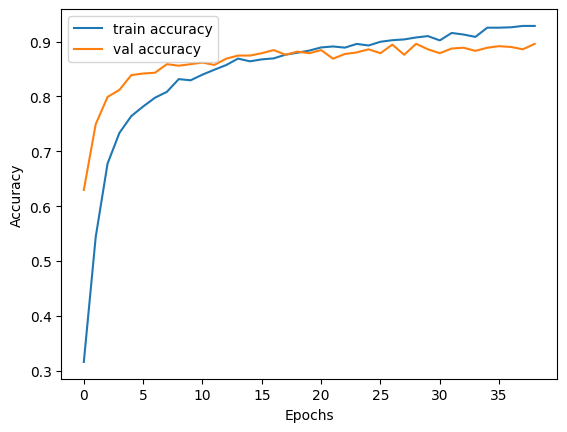

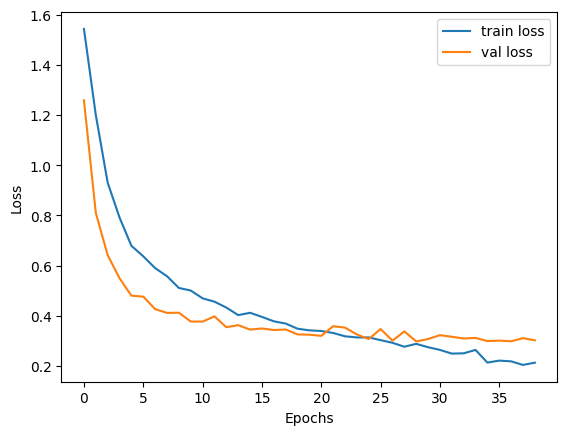

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Load the saved data
train_features = np.load('train_features.npy')
test_features = np.load('test_features.npy')
train_masks = np.load('train_masks.npy')
test_masks = np.load('test_masks.npy')
train_labels = np.load('train_labels.npy')
test_labels = np.load('test_labels.npy')

# Verify the shape of train_features
print(f"Train features shape: {train_features.shape}")

# Define constants
SEQUENCE_LENGTH = train_features.shape[1]
NUM_FEATURES = train_features.shape[2]
CLASSES_LIST = ['BaseLayer_Preparation', 'Concrete_Placement', 'Mortar_Preparation', 'Plaster', 'Wall Construction']

# Define the model
def create_LRCN_model(sequence_length, num_features, num_classes):
    model = Sequential([
        LSTM(64, return_sequences=False, input_shape=(sequence_length, num_features), dropout=0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    model.summary()
    return model

input_shape = (SEQUENCE_LENGTH, NUM_FEATURES)
num_classes = len(CLASSES_LIST)
LRCN_model = create_LRCN_model(SEQUENCE_LENGTH, NUM_FEATURES, num_classes)

# Compile the model
adam = Adam(learning_rate=0.0001)
LRCN_model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=["accuracy"])

# Train the model
LRCN_model_training_history = None  # Initialize to None for error handling
try:
    LRCN_model_training_history = LRCN_model.fit(
        x=train_features,
        y=train_labels,
        epochs=50,
        batch_size=4,
        shuffle=True,
        validation_data=(test_features, test_labels),
        callbacks=[
            EarlyStopping(patience=10, restore_best_weights=True),
            ReduceLROnPlateau(patience=5),
            ModelCheckpoint('best_model.keras', save_best_only=True)
        ]
    )
except Exception as e:
    print(f"Error during training: {e}")

# Check if training history is available before plotting
if LRCN_model_training_history:
    # Plot training history
    plt.plot(LRCN_model_training_history.history['accuracy'], label='train accuracy')
    plt.plot(LRCN_model_training_history.history['val_accuracy'], label='val accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.plot(LRCN_model_training_history.history['loss'], label='train loss')
    plt.plot(LRCN_model_training_history.history['val_loss'], label='val loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
else:
    print("Training was not completed successfully.")


In [2]:
# Define constants
BATCH_SIZE = 4  # Define your desired batch size

# Evaluate the model on the test set
test_loss, test_accuracy = LRCN_model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9127 - loss: 0.2654
Test Accuracy: 89.60%
Test Loss: 0.2981


176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


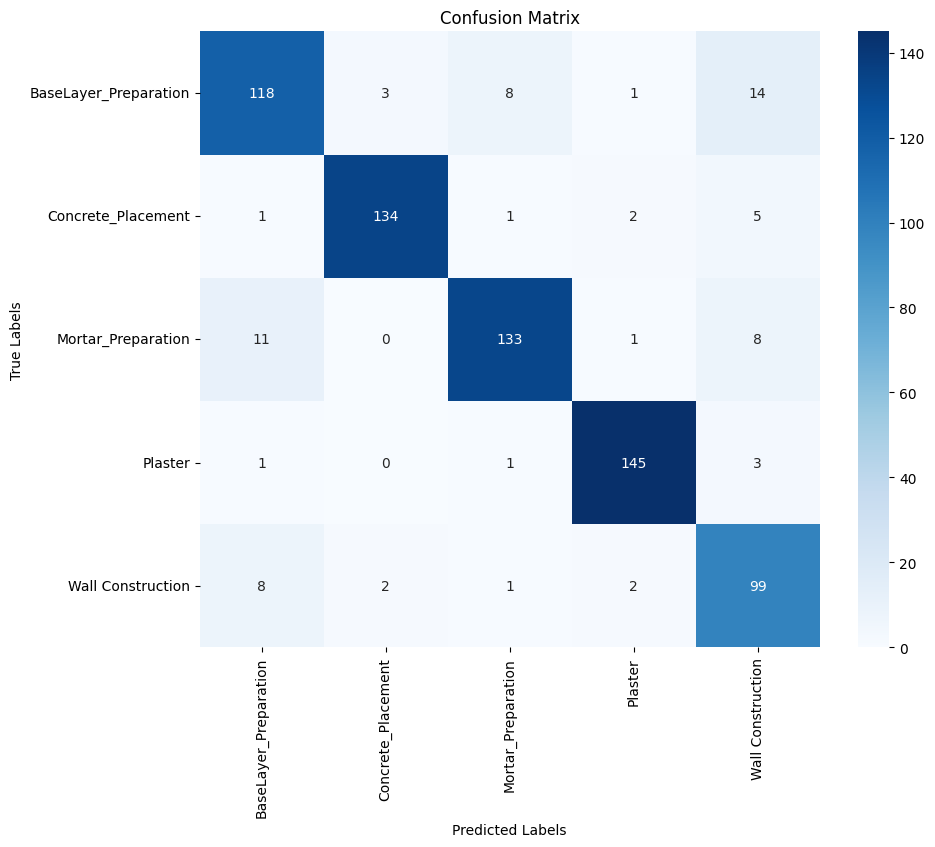

Classification Report:
                        precision    recall  f1-score   support

BaseLayer_Preparation       0.85      0.82      0.83       144
   Concrete_Placement       0.96      0.94      0.95       143
   Mortar_Preparation       0.92      0.87      0.90       153
              Plaster       0.96      0.97      0.96       150
    Wall Construction       0.77      0.88      0.82       112

             accuracy                           0.90       702
            macro avg       0.89      0.90      0.89       702
         weighted avg       0.90      0.90      0.90       702



In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


# Predict the labels for the test set
test_predictions = LRCN_model.predict(test_features, batch_size=BATCH_SIZE)
test_pred_labels = np.argmax(test_predictions, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(test_labels, test_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES_LIST, yticklabels=CLASSES_LIST)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
class_report = classification_report(test_labels, test_pred_labels, target_names=CLASSES_LIST)
print("Classification Report:\n", class_report)
